In [1]:
import torch
import torch.distributions as distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, os

from torch.utils.data import TensorDataset
from torch.optim import lr_scheduler
from tqdm import trange

class Hyperparameters():
    def __init__(self, base_dim, weight_norm, coupling_bn):
        self.base_dim = base_dim
        self.weight_norm = weight_norm
        self.coupling_bn = coupling_bn
        
class WeightNormFC(nn.Module):
    def __init__(self, in_dim, out_dim, weight_norm=True, scale=False):
        
        super(WeightNormFC, self).__init__()

        if weight_norm:
            self.dense = nn.utils.weight_norm(nn.Linear(in_dim, out_dim))
            
            if not scale:
                self.dense.weight_g.data = torch.ones_like(self.dense.weight_g.data)
                self.dense.weight_g.requires_grad = False    # freeze scaling
        else:
            self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.dense(x)
    
    
class DenseModule(nn.Module):
    def __init__(self, in_dim, dim, out_dim, weight_norm):
        
        super(DenseModule, self).__init__()
        
        self.block = nn.Sequential(WeightNormFC(in_dim, dim, weight_norm),
                                   nn.ReLU(),
                                   WeightNormFC(dim, dim, weight_norm),
                                   nn.ReLU(),
                                   WeightNormFC(dim, out_dim, weight_norm))

    def forward(self, x):
        return self.block(x)

    
class AbstractCoupling(nn.Module):
    def __init__(self, mask_config, hps):
        super(AbstractCoupling, self).__init__()
      
        self.weight_norm = hps.weight_norm
        self.coupling_bn = hps.coupling_bn
        self.mask_config = mask_config

    def batch_stat(self, x):
        mean = torch.mean(x, dim=0, keepdim=True)
        var = torch.mean((x - mean)**2, dim=0, keepdim=True)
        return mean, var

    
class ChannelwiseAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        
        super(ChannelwiseAffineCoupling, self).__init__(mask_config, hps)
        
        self.s_net = DenseModule(in_out_dim//2, mid_dim, in_out_dim//2, self.weight_norm)
        self.t_net = DenseModule(in_out_dim//2, mid_dim, in_out_dim//2, self.weight_norm)
        
    def forward(self, x, reverse=False):
        [_, D] = list(x.size())
        
        if self.mask_config:
            (on, off) = x.split(D//2, dim=1)
        else:
            (off, on) = x.split(D//2, dim=1)
                
        if reverse == False:
            # Forward
            self.scale = self.s_net(off)
            self.trans = self.t_net(off)
            
            on = (torch.exp(torch.atan(self.scale))) * on + self.trans
            log_det_J = torch.sum(torch.atan(self.scale), dim=1)
            
            if self.coupling_bn:
                mean, var = self.batch_stat(on)
                on = self.out_bn(on)
                on = (on - mean) / torch.sqrt(var + 1e-5)
                log_det_J = log_det_J - 0.5 * torch.sum(torch.log(var + 1e-5), dim=1)

        else:
            # Reverse
            self.scale = self.s_net(off)
            self.trans = self.t_net(off)
            log_det_J = torch.zeros(off.shape[0]).to(x.device)
            
            if self.coupling_bn:
                mean, var = self.batch_stat(on)
                on = on * torch.exp(0.5 * torch.log(var + 1e-5)) + mean
#                 on = on * torch.sqrt(var + 1e-5) + mean
                log_det_J = 0.5 * torch.sum(torch.log(var + 1e-5), dim=1)
            
#             on = (on - self.trans) / (torch.exp(0.636 *2* torch.atan(self.scale)))
#             log_det_J = log_det_J - torch.sum(0.636 *2* torch.atan(self.scale), dim=1)
            on = (on - self.trans) / (torch.exp(torch.atan(self.scale)))
            log_det_J = log_det_J - torch.sum(torch.atan(self.scale), dim=1)
        
        if self.mask_config:
            x = torch.cat((on, off), 1)
        else:
            x = torch.cat((off, on), 1)
        
        return x, log_det_J 
    
class ChannelwiseCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        super(ChannelwiseCoupling, self).__init__()

        self.coupling = ChannelwiseAffineCoupling(in_out_dim, mid_dim, mask_config, hps)


    def forward(self, x, reverse=False):
        return self.coupling(x, reverse)
        
    
class RealNVP(nn.Module):
    def __init__(self, in_out_dim, hps):
        super(RealNVP, self).__init__()
        
        self.hps = hps
        mid_dim = hps.base_dim
        self.in_out_dim = in_out_dim
        self.s1_chan = self.channelwise_combo(in_out_dim, mid_dim, hps)
        
    def channelwise_combo(self, in_out_dim, mid_dim, hps):
        return nn.ModuleList([
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps)])

    def forward(self, x, reverse=False):
        log_det_J = torch.zeros(x.size()[0]).to(x.device)

        if reverse == False:
            for i in range(len(self.s1_chan)):
                x, inc = self.s1_chan[i](x)
                log_det_J = log_det_J + inc
        else:            
            for i in reversed(range(len(self.s1_chan))):
                x, inc = self.s1_chan[i](x, reverse=True)
                log_det_J = log_det_J + inc
                
        return x, log_det_J
        
    def weight_reg(self, x):
        
        weight_scale = None
        for name, param in self.named_parameters():
            param_name = name.split('.')[-1]
            if param_name in ['weight_g', 'scale'] and param.requires_grad:
                if weight_scale is None:
                    weight_scale = torch.pow(param, 2).sum()
                else:
                    weight_scale = weight_scale + torch.pow(param, 2).sum()
        return weight_scale
    
device = torch.device("cuda:0")
hps = Hyperparameters(
    base_dim=48,      
    weight_norm=False, 
    coupling_bn=False)

In [2]:
f = np.load('./Data/Inverse_Kinematics_Data.npz')
x_data = f['x_data']
y_data = f['y_data']
xi_data = f['xi_data']

sigma_1 = 0.25
sigma_2 = 0.5
sigma_3 = 0.5
sigma_4 = 0.5
l1 = 0.5
l2 = 0.5
l3 = 1.0

ndim_x = xi_data.shape[1]
ndim_y = y_data.shape[1]
ndim_z = 2

# prepare dataset
Num_data = len(x_data)
input_data = xi_data.astype(np.float32)
output_data = y_data[0:Num_data].astype(np.float32)
N_train = 4000
N_test = 1000
x_train = torch.from_numpy(input_data[0:N_train])
y_train = torch.from_numpy(output_data[0:N_train])
x_test = torch.from_numpy(input_data[N_train:N_train+N_test])
y_test = torch.from_numpy(output_data[N_train:N_train+N_test])

batch_size = 64
torch.manual_seed(2022)
train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size,
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size,
                                           shuffle=True, drop_last=True)
prior = distributions.Normal(
    torch.tensor(0.).to(device), torch.tensor(1.).to(device))
latent = distributions.Normal(
    torch.tensor(0.).to(device), torch.tensor(1.).to(device))

In [3]:
def loss_forward(output, target):
    """
    Forward fitting loss
    """
    return torch.mean((output - target) ** 2)

def log_q_yz(out_x, log_det_J):
    """
    Log Joint distribution of INN output
    """
    log_px = torch.sum(prior.log_prob(out_x), dim=1)
    return log_px + log_det_J

def loss_independence(out_x, log_det_J, out_x_star, log_det_J_star, normal_dist):
    """
    Independence loss
    """
    return torch.mean(torch.square(log_q_yz(out_x, log_det_J) - log_q_yz(out_x_star, log_det_J_star) - normal_dist))

def train(device):
    running_loss = 0.
    running_l2_fit = 0.
    running_ind = 0.
    INN.train()
    
    for batch_idx, (x, y) in enumerate(train_loader):
        batch_idx += 1
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        z_star = torch.randn(len(x), ndim_z).to(device)
        out_yz = INN(x)[0]
        
        out_z = out_yz[:, -ndim_z:]
        yz = torch.cat((out_yz[:, 0:ndim_y], z_star), dim=1)
        out_x, log_det_J = INN(out_yz, reverse=True)
        out_x_star, log_det_J_star = INN(yz, reverse=True)
        normal_dist = torch.sum(latent.log_prob(out_z) - latent.log_prob(z_star), dim=1)
        ind_loss = loss_independence(out_x, log_det_J, out_x_star, log_det_J_star, normal_dist)
        
        l2_fwd_fit = loss_forward(out_yz[:, 0:ndim_y], y[:, 0:ndim_y])
        loss = weight_fwd * l2_fwd_fit + weight_ind * ind_loss
        
        running_loss += loss.item()
        running_l2_fit += l2_fwd_fit.item()
        running_ind += ind_loss.item()

        loss.backward()
        optimizer.step()
    
    mean_loss = running_loss / batch_idx
    mean_l2_fit = running_l2_fit / batch_idx
    mean_ind = running_ind / batch_idx
    total_trn_loss_lst.append(mean_loss)
    forward_trn_loss_lst.append(mean_l2_fit)
    ind_trn_loss_lst.append(mean_ind)
    
    print('===> Average train loss: %.6f,\t l2 fit loss: %.6f,\t ind loss: %.6f' % 
          (mean_loss, mean_l2_fit, mean_ind))
    return mean_loss
    
def test(device):
    running_loss = 0.
    running_l2_fit = 0.
    running_ind = 0.
    INN.eval()
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            batch_idx += 1
            x, y = x.to(device), y.to(device)
            z_star = torch.randn(len(x), ndim_z).to(device)
            out_yz = INN(x)[0]

            out_z = out_yz[:, -ndim_z:]
            yz = torch.cat((out_yz[:, 0:ndim_y], z_star), dim=1)
            out_x, log_det_J = INN(out_yz, reverse=True)
            out_x_star, log_det_J_star = INN(yz, reverse=True)
            normal_dist = torch.sum(latent.log_prob(out_z) - latent.log_prob(z_star), dim=1)
            ind_loss = loss_independence(out_x, log_det_J, out_x_star, log_det_J_star, normal_dist)
            
            l2_fwd_fit = loss_forward(out_yz[:, 0:ndim_y], y[:, 0:ndim_y])
            loss = weight_fwd * l2_fwd_fit + weight_ind * ind_loss

            running_loss += loss.item()
            running_l2_fit += l2_fwd_fit.item()
            running_ind += ind_loss.item()
    
    mean_loss = running_loss / batch_idx
    mean_l2_fit = running_l2_fit / batch_idx
    mean_ind = running_ind / batch_idx
    total_test_loss_lst.append(mean_loss)
    forward_test_loss_lst.append(mean_l2_fit)
    ind_test_loss_lst.append(mean_ind)
    
    print('===> Average test loss: %.6f,\t l2 fit loss: %.6f,\t ind loss: %.6f' % 
          (mean_loss, mean_l2_fit, mean_ind))
    return mean_loss

In [ ]:
max_epoch = 5000
epoch = 0
weight_fwd = 1.
weight_ind = 0.01

total_trn_loss_lst, total_test_loss_lst = [], []
forward_trn_loss_lst, forward_test_loss_lst = [], []
ind_trn_loss_lst, ind_test_loss_lst = [], []

model_path = './models/INN_Kinematics.pt'
if not os.path.exists(model_path):
    try:
        torch.manual_seed(2022)
        torch.cuda.manual_seed(2022)
        INN = RealNVP(ndim_x, hps=hps).to(device)

        lr = 5e-4
        momentum = 0.9
        decay = 0.99
        optimizer = optim.Adam(INN.parameters(), lr=lr, betas=(momentum, decay), eps=1e-7)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.8, verbose=False)
        
        optimal_loss = float('inf')
        start_time = time.time()

        for epoch in range(max_epoch):
            print('Epoch %d:' % epoch)
            loss_trn = train(device)
            loss_test = test(device)
#             if optimal_loss > loss_test:
#                 optimal_loss = loss_test
#                 torch.save(INN, model_path)
            scheduler.step()

    except KeyboardInterrupt:
        pass
    finally:
        torch.save(INN, './models/INN_Kinematics.pt')
#         print("==> Best test loss: %.6f" % (optimal_loss))
        print("Time elapsed:", time.time() - start_time)
else:
    INN = torch.load(model_path).to(device)

In [17]:
# os.remove(model_path)

In [ ]:
def l2_relative_error(y, y_pred):
    return torch.norm(y - y_pred, dim=1) / torch.norm(y, dim=1)

##############################
####### forward test #########
##############################
yz_pred = INN(x_test.to(device))[0]
y_pred, z_pred = yz_pred[:, 0:ndim_y], yz_pred[:, -ndim_z:]

# test y
l2_err_y = l2_relative_error(y_pred, y_test.to(device))
print("mean l2_relative_error for y:", l2_err_y.mean().item())

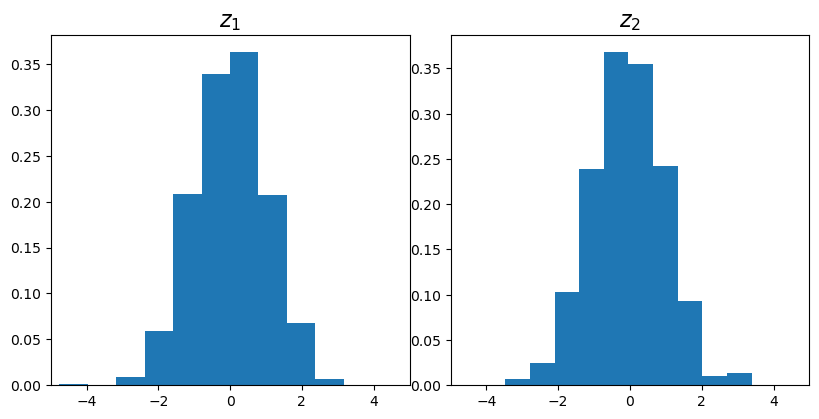

In [6]:
# test z
plt.style.use('default')
fig = plt.figure(figsize=(8, 4))

for i in range(ndim_z):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(z_pred.cpu().detach().numpy()[:, i], density=True)
    ax.set_xlim([-5, 5])
    ax.set_title(r'$z_{%d}$' % (i+1), fontsize=16)

plt.tight_layout(pad=0.02)

In [ ]:
#####################################
######### Bayesian sampling #########
#####################################
def concatenate_test_set():
    x_all, y_all = [], []

    for x,y in test_loader:
        x_all.append(x)
        y_all.append(y)

    return torch.cat(x_all, 0), torch.cat(y_all, 0)
x_all, y_all = concatenate_test_set()

def sample_posterior(INN, y_it, N=4096):
    outputs = []
    for y in y_it:

        rev_inputs = torch.cat([torch.zeros(N, ndim_y), torch.randn(N, ndim_z)], 1).to(device)
        rev_inputs[:, 0:ndim_y] = y

        with torch.no_grad():
            x_samples = INN(rev_inputs.to(device), reverse=True)[0].to(device)
        outputs.append(x_samples.data.cpu().numpy())
    return outputs

def show_posteriors(INN):
    n_plots = 5
    n_x = 4

    def hists(x):
        results = []
        for j in range(n_x):
            h, b = np.histogram(x[:, j], bins=100, range=(-2,2), density=True)
            h /= np.max(h)
            results.append([b[:-1],h])
        return results

    prior_hists = hists(x_all)

    x_gt = x_all[:n_plots]
    y_gt = y_all[:n_plots]

    posteriors = sample_posterior(INN, y_gt)

    confidence = 0.68
    q_low  = 100. * 0.5 * (1 - confidence)
    q_high = 100. * 0.5 * (1 + confidence)

    for i in range(n_plots):
        hist_i = hists(posteriors[i])

        for j in range(n_x):
            plt.subplot(n_plots, n_x, n_x*i + j + 1)
            plt.step(*(prior_hists[j]), where='post', color='grey') 
            plt.step(*(hist_i[j]), where='post', color='blue')

            x_low, x_high = np.percentile(posteriors[i][:,j], [q_low, q_high])
            plt.plot([x_gt[i,j], x_gt[i,j]], [0,1], color='black')
            plt.plot([x_low, x_low], [0,1], color='orange')
            plt.plot([x_high, x_high], [0,1], color='orange')
    plt.tight_layout()

def calibration_error(INN, x_ind=0):
    x_ind = 0
    n_steps = 100
    
    q_values = []
    confidences = np.linspace(0., 1., n_steps+1, endpoint=False)[1:]
    uncert_intervals = [[] for i in range(n_steps)]
    inliers = [[] for i in range(n_steps)]

    for conf in confidences:
        q_low  = 0.5 * (1 - conf)
        q_high = 0.5 * (1 + conf)
        q_values += [q_low, q_high]

    from tqdm import tqdm
    for x,y in tqdm(zip(x_all, y_all), total=x_all.shape[0], disable=False):
        post = sample_posterior(INN, [y])[0][:, x_ind]
        x_margins = list(np.quantile(post, q_values))

        for i in range(n_steps):
            x_low, x_high = x_margins.pop(0), x_margins.pop(0) 

            uncert_intervals[i].append(x_high - x_low)
            inliers[i].append(int(x[x_ind] < x_high and x[x_ind] > x_low))

    inliers = np.mean(inliers, axis=1)
    uncert_intervals = np.median(uncert_intervals, axis=1)
    calib_err = inliers - confidences
    
    return np.median(np.abs(calib_err)), calib_err

def from_params_to_terminal(x_sample):
    x1, x2, x3, x4 = x_sample[:, 0:1], x_sample[:, 1:2], x_sample[:, 2:3], x_sample[:, 3:]
    y1_predict = x1 + l1 * np.sin(x2) + l2 * np.sin(x3 - x2) + l3 * np.sin(x4 - x3 - x2)
    y2_predict = l1 * np.cos(x2) + l2 * np.cos(x3 - x2) + l3 * np.cos(x4 - x2 - x3)
    return np.concatenate([y1_predict, y2_predict], axis=1)

def resimulate_error(INN, x_ind=0):
    N = 4096
    l2_resim_err_lst = []
    for x, y in tqdm(zip(x_all, y_all), total=x_all.shape[0], disable=False):
        post = sample_posterior(INN, [y])[0]
        y_resim = from_params_to_terminal(post)
        l2_resim_err = np.linalg.norm(y - y_resim, axis=1) / np.linalg.norm(y)
        l2_resim_err_lst.append(l2_resim_err)          
    return np.concatenate(l2_resim_err_lst)

In [8]:
######################## INN 1 #########################
print("x1:")
INN_calib_median_x1, _ = calibration_error(INN, x_ind=0)
print(F'Median calibration error: {INN_calib_median_x1}')
print("x2:")
INN_calib_median_x2, _ = calibration_error(INN, x_ind=1)
print(F'Median calibration error: {INN_calib_median_x2}')
print("x3:")
INN_calib_median_x3, _ = calibration_error(INN, x_ind=2)
print(F'Median calibration error: {INN_calib_median_x3}')
print("x4:")
INN_calib_median_x4, _ = calibration_error(INN, x_ind=3)
print(F'Median calibration error: {INN_calib_median_x4}')

x1:


100%|██████████████████████████████| 960/960 [00:07<00:00, 123.72it/s]


Median calibration error: 0.006693481848184829
x2:


100%|██████████████████████████████| 960/960 [00:07<00:00, 124.06it/s]


Median calibration error: 0.008405528052805283
x3:


100%|███████████████████████████████| 960/960 [00:10<00:00, 95.89it/s]


Median calibration error: 0.00560024752475248
x4:


100%|██████████████████████████████| 960/960 [00:07<00:00, 124.58it/s]


Median calibration error: 0.006992574257425721


In [ ]:
# def from_params_to_terminal(x_sample):
#     x1, x2 = x_sample[:, 0:1] * sigma_1, x_sample[:, 1:2] * sigma_2
#     x3, x4 = x_sample[:, 2:3] * sigma_3, x_sample[:, 3:] * sigma_4
#     y1_predict = x1 + l1 * np.sin(x2) + l2 * np.sin(x3 - x2) + l3 * np.sin(x4 - x3 - x2)
#     y2_predict = l1 * np.cos(x2) + l2 * np.cos(x3 - x2) + l3 * np.cos(x4 - x2 - x3)
#     return np.concatenate([y1_predict, y2_predict], axis=1)

# def Resimulation_Error(x_sample, y_observation):
#     y_observation = y_observation.cpu().detach().numpy()
#     l2_err_resimulate = np.zeros([N_test, x_sample.shape[1]])
#     pbar = trange(N_test)
#     for i in pbar:
#         x_sample_i = x_sample[i]
#         y_resimualte_i = from_params_to_terminal(x_sample_i)
#         l2_err_resimulate[i] = np.linalg.norm(y_observation[i:(i+1)] - y_resimualte_i, axis=1) / np.linalg.norm(y_observation[i:(i+1)])
#     return l2_err_resimulate

# N_post = 2000
# INN_sample = np.array(sample_posterior(INN, y_test, N_post))
# resim_err_test = Resimulation_Error(INN_sample, y_test)

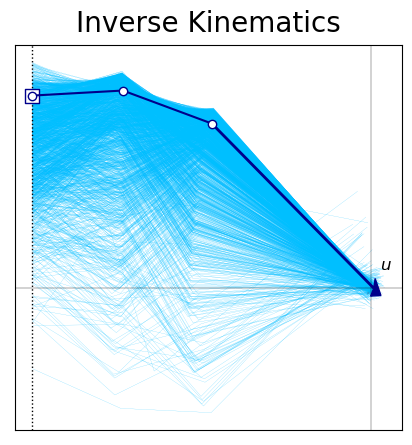

In [10]:
def from_params_to_trajectory(x_sample):
    y1_traj, y2_traj = np.zeros([len(x_sample), 4]), np.zeros([len(x_sample), 4])
    x1, x2 = x_sample[:, 0] * sigma_1, x_sample[:, 1] * sigma_2
    x3, x4 = x_sample[:, 2] * sigma_3, x_sample[:, 3] * sigma_4
    
    y1_traj[:, 0] = x1
    y1_traj[:, 1] = y1_traj[:, 0] + l1 * np.sin(x2)
    y1_traj[:, 2] = y1_traj[:, 1] + l2 * np.sin(x3 - x2)
    y1_traj[:, 3] = y1_traj[:, 2] + l3 * np.sin(x4 - x3 - x2)
    y2_traj[:, 1] = l1 * np.cos(x2)
    y2_traj[:, 2] = y2_traj[:, 1] + l2 * np.cos(x3 - x2)
    y2_traj[:, 3] = y2_traj[:, 2] + l3 * np.cos(x4 - x2 - x3)
    return y1_traj, y2_traj

def visualize_trajectory(y1_traj, y2_traj, y_exact):
    plt.style.use('default')
    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_subplot(1, 1, 1)
    for i in range(N_post):
        ax.plot(y2_traj[i], y1_traj[i], linestyle='-', linewidth=0.1, color='deepskyblue')

    ax.plot(y2_traj[idx_test, :-1], y1_traj[idx_test, :-1], marker='o', markerfacecolor='w', linestyle='-', 
             markeredgewidth=1, color='darkblue', zorder=2.5)
    ax.scatter(y_exact[1], y_exact[0], s=80, marker='*', c='r')
    ax.arrow(x=y2_traj[idx_test, -2], y=y1_traj[idx_test, -2], dx=y2_traj[idx_test, -1]-y2_traj[idx_test, -2], 
              dy=y1_traj[idx_test, -1]-y1_traj[idx_test, -2], color='darkblue', width=0.005, head_width=0.055,
              overhang=0.1, head_length=0.05, zorder=2.5)

    ax.axvline(x=0, linestyle=':', color='k', linewidth=1)
    ax.axvline(x=y_exact[1], color='k', linewidth=0.25)
    ax.axhline(y=y_exact[0], color='k', linewidth=0.25)

    ax.scatter(y2_traj[idx_test, 0], y1_traj[idx_test, 0], marker='s', s=90, color='w', edgecolors='darkblue', zorder=2.5)
    ax.text(x=y_exact[1]+0.05, y=y_exact[0]+0.05, s=r'$u$', fontsize=12)
    ax.set_title('Inverse Kinematics', fontsize=20, pad=9.5)
    ax.set_xticks([])
    ax.set_yticks([])
    
idx_test = 60
y1_traj, y2_traj = from_params_to_trajectory(INN_sample[idx_test])
y_exact = y_test[idx_test].cpu().detach().numpy()
visualize_trajectory(y1_traj, y2_traj, y_exact)